In [1]:
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# sys.pathの設定
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

勾配消失問題 modified       
multi layer network class

In [7]:
import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt

class MultiLayerNet:
  '''
  input_size : 入力層のノード数
  hidden_size_list : 隠れ層のノード数のリスト
  output_size : 出力層のノード数
  activation : 活性化関数
  weight_init_std : 重みの初期化方法
  '''
  def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu'):
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size_list = hidden_size_list
    self.hidden_layer_num = len(hidden_size_list)
    self.params = {}

    # 重みの初期化
    self.__init_weight(weight_init_std)

    # レイヤの生成（sigmoid, reluのみ扱う）
    activation_layer = {'sigmoid' : layers.Sigmoid, 'relu' : layers.Relu}
    self.layers = OrderedDict()
    for idx in range(1, self.hidden_layer_num+1):
      self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
      self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

    idx = self.hidden_layer_num + 1
    self.layers['Affine' +str(idx)] = layers.Affine(self.params['W' +str(idx)], self.params['b' +str(idx)])
    self.last_layer = layers.SoftmaxWithLoss()

    # 重みの初期化
  def __init_weight(self, weight_init_std):
      all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
      for idx in range(1, len(all_size_list)):
          scale = weight_init_std
          if str(weight_init_std).lower() in ('relu', 'he'):
              scale = np.sqrt(2.0 / all_size_list[idx - 1])
          elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
              scale = np.sqrt(1.0 / all_size_list[idx - 1])

          self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
          self.params['b' + str(idx)] = np.zeros(all_size_list[idx])


  def predict(self, x):
      for layer in self.layers.values():
          x = layer.forward(x)

      return x


  def loss(self, x, d):
      y = self.predict(x)

      weight_decay = 0
      for idx in range(1, self.hidden_layer_num + 2):
          W = self.params['W' + str(idx)]

      return self.last_layer.forward(y, d) + weight_decay


  def accuracy(self, x, d):
      y = self.predict(x)
      y = np.argmax(y, axis=1)
      if d.ndim != 1 : d = np.argmax(d, axis=1)

      accuracy = np.sum(y == d) / float(x.shape[0])
      return accuracy


  def gradient(self, x, d):
      # forward
      self.loss(x, d)

      # backward
      dout = 1
      dout = self.last_layer.backward(dout)

      layers = list(self.layers.values())
      layers.reverse()
      for layer in layers:
          dout = layer.backward(dout)

      # 設定
      grad = {}
      for idx in range(1, self.hidden_layer_num+2):
          grad['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
          grad['b' + str(idx)] = self.layers['Affine' + str(idx)].db

      return grad


sigmoid関数 - gauss分布

Generation: 10.正答率（train) = 0.13
             :10.正答率(test) =0.1135
Generation: 20.正答率（train) = 0.17
             :20.正答率(test) =0.1135
Generation: 30.正答率（train) = 0.13
             :30.正答率(test) =0.1135
Generation: 40.正答率（train) = 0.12
             :40.正答率(test) =0.1135
Generation: 50.正答率（train) = 0.07
             :50.正答率(test) =0.1135
Generation: 60.正答率（train) = 0.09
             :60.正答率(test) =0.1135
Generation: 70.正答率（train) = 0.12
             :70.正答率(test) =0.1135
Generation: 80.正答率（train) = 0.11
             :80.正答率(test) =0.1135
Generation: 90.正答率（train) = 0.09
             :90.正答率(test) =0.1028
Generation: 100.正答率（train) = 0.11
             :100.正答率(test) =0.1135
Generation: 110.正答率（train) = 0.12
             :110.正答率(test) =0.1135
Generation: 120.正答率（train) = 0.1
             :120.正答率(test) =0.1135
Generation: 130.正答率（train) = 0.13
             :130.正答率(test) =0.1135
Generation: 140.正答率（train) = 0.08
             :140.正答率(test) =0.1028
Generation: 150.正答率（train) = 0.07
     

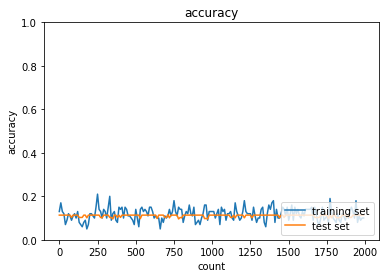

In [8]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  d_batch = d_train[batch_mask]

  # 勾配
  grad = network.gradient(x_batch, d_batch)
  for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, d_batch)
  train_loss_list.append(loss)


  if (i + 1) % plot_interval == 0:
    accr_test = network.accuracy(x_test, d_test)
    accuracies_test.append(accr_test)
    accr_train = network.accuracy(x_batch, d_batch)
    accuracies_train.append(accr_train)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()


活性化関数：ReLU、重みの初期値：gauss

Generation: 10.正答率（train) = 0.08
             :10.正答率(test) =0.1135
Generation: 20.正答率（train) = 0.11
             :20.正答率(test) =0.1135
Generation: 30.正答率（train) = 0.09
             :30.正答率(test) =0.1135
Generation: 40.正答率（train) = 0.13
             :40.正答率(test) =0.1135
Generation: 50.正答率（train) = 0.03
             :50.正答率(test) =0.1135
Generation: 60.正答率（train) = 0.09
             :60.正答率(test) =0.1135
Generation: 70.正答率（train) = 0.16
             :70.正答率(test) =0.1135
Generation: 80.正答率（train) = 0.09
             :80.正答率(test) =0.1028
Generation: 90.正答率（train) = 0.12
             :90.正答率(test) =0.1135
Generation: 100.正答率（train) = 0.11
             :100.正答率(test) =0.1135
Generation: 110.正答率（train) = 0.04
             :110.正答率(test) =0.1135
Generation: 120.正答率（train) = 0.07
             :120.正答率(test) =0.1135
Generation: 130.正答率（train) = 0.13
             :130.正答率(test) =0.1135
Generation: 140.正答率（train) = 0.18
             :140.正答率(test) =0.1135
Generation: 150.正答率（train) = 0.07
    

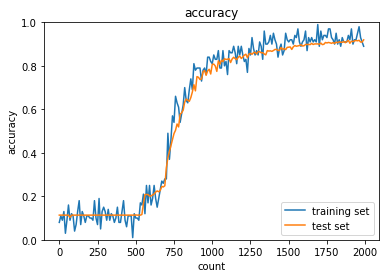

In [9]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  d_batch = d_train[batch_mask]

  # 勾配
  grad = network.gradient(x_batch, d_batch)
  for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, d_batch)
  train_loss_list.append(loss)


  if (i + 1) % plot_interval == 0:
    accr_test = network.accuracy(x_test, d_test)
    accuracies_test.append(accr_test)
    accr_train = network.accuracy(x_batch, d_batch)
    accuracies_train.append(accr_train)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()


活性化関数：sigmoid, 重みの初期値：Xavier

Generation: 10.正答率（train) = 0.11
             :10.正答率(test) =0.1135
Generation: 20.正答率（train) = 0.08
             :20.正答率(test) =0.1135
Generation: 30.正答率（train) = 0.1
             :30.正答率(test) =0.1202
Generation: 40.正答率（train) = 0.21
             :40.正答率(test) =0.194
Generation: 50.正答率（train) = 0.17
             :50.正答率(test) =0.1553
Generation: 60.正答率（train) = 0.22
             :60.正答率(test) =0.1891
Generation: 70.正答率（train) = 0.38
             :70.正答率(test) =0.3036
Generation: 80.正答率（train) = 0.29
             :80.正答率(test) =0.2077
Generation: 90.正答率（train) = 0.25
             :90.正答率(test) =0.3379
Generation: 100.正答率（train) = 0.31
             :100.正答率(test) =0.2987
Generation: 110.正答率（train) = 0.18
             :110.正答率(test) =0.1727
Generation: 120.正答率（train) = 0.14
             :120.正答率(test) =0.1391
Generation: 130.正答率（train) = 0.15
             :130.正答率(test) =0.1592
Generation: 140.正答率（train) = 0.26
             :140.正答率(test) =0.3263
Generation: 150.正答率（train) = 0.4
       

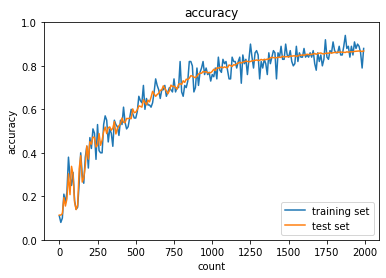

In [10]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  d_batch = d_train[batch_mask]

  # 勾配
  grad = network.gradient(x_batch, d_batch)
  for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, d_batch)
  train_loss_list.append(loss)


  if (i + 1) % plot_interval == 0:
    accr_test = network.accuracy(x_test, d_test)
    accuracies_test.append(accr_test)
    accr_train = network.accuracy(x_batch, d_batch)
    accuracies_train.append(accr_train)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()


活性化関数：Relu, 重みの初期値：He

Generation: 10.正答率（train) = 0.48
             :10.正答率(test) =0.3985
Generation: 20.正答率（train) = 0.59
             :20.正答率(test) =0.5125
Generation: 30.正答率（train) = 0.82
             :30.正答率(test) =0.6604
Generation: 40.正答率（train) = 0.83
             :40.正答率(test) =0.7591
Generation: 50.正答率（train) = 0.81
             :50.正答率(test) =0.7926
Generation: 60.正答率（train) = 0.81
             :60.正答率(test) =0.785
Generation: 70.正答率（train) = 0.8
             :70.正答率(test) =0.8327
Generation: 80.正答率（train) = 0.89
             :80.正答率(test) =0.8231
Generation: 90.正答率（train) = 0.82
             :90.正答率(test) =0.8473
Generation: 100.正答率（train) = 0.89
             :100.正答率(test) =0.8571
Generation: 110.正答率（train) = 0.91
             :110.正答率(test) =0.8569
Generation: 120.正答率（train) = 0.87
             :120.正答率(test) =0.8365
Generation: 130.正答率（train) = 0.98
             :130.正答率(test) =0.8785
Generation: 140.正答率（train) = 0.9
             :140.正答率(test) =0.8743
Generation: 150.正答率（train) = 0.91
       

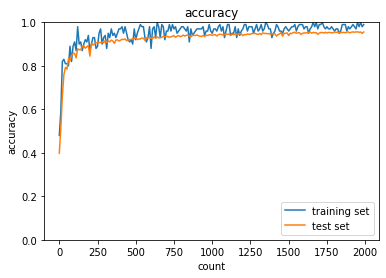

In [11]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  d_batch = d_train[batch_mask]

  # 勾配
  grad = network.gradient(x_batch, d_batch)
  for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, d_batch)
  train_loss_list.append(loss)


  if (i + 1) % plot_interval == 0:
    accr_test = network.accuracy(x_test, d_test)
    accuracies_test.append(accr_test)
    accr_train = network.accuracy(x_batch, d_batch)
    accuracies_train.append(accr_train)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()
